In [2]:
import numpy as np
from skimage import io, util, measure, transform
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
# from scipy.interpolate import NearestNDInterpolator

from measurements import get_mesh_from_bm_image,get_tissue_curvature_sparse, export_mesh
from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

%load_ext autoreload
%autoreload 2


In [3]:
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Fixed/12-05-2025 Whole skin whole mount/Hoechst K10488 Phall594 Cdh5/3/'

height_image = io.imread(path.join(dirname,'height_image.tif'))
heightmap = io.imread(path.join(dirname,'heightmap.tif'))

stackview.slice(height_image, zoom_factor=0.5)

In [ ]:
from measurements import get_tissue_curvature_over_grid

dx = 0.2071607
dz = .5

#Trim to the 'center' to avoid the artifacts on edges
Ytrim = slice(0,800)
Xtrim = slice(200,800)

mesh = get_mesh_from_bm_image(height_image,spacing=[dz,dx,dx],decimation_factor=60)
export_mesh(mesh,path.join(dirname,'mesh.npz'))

mean_curv,gaussian_curv = get_tissue_curvature_over_grid(mesh,image_shape=height_image.shape)

In [9]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(mesh)
pl.show(jupyter_backend='trame')

Widget(value='<iframe src="http://localhost:51776/index.html?ui=P_0x176859340_1&reconnect=auto" class="pyvista…

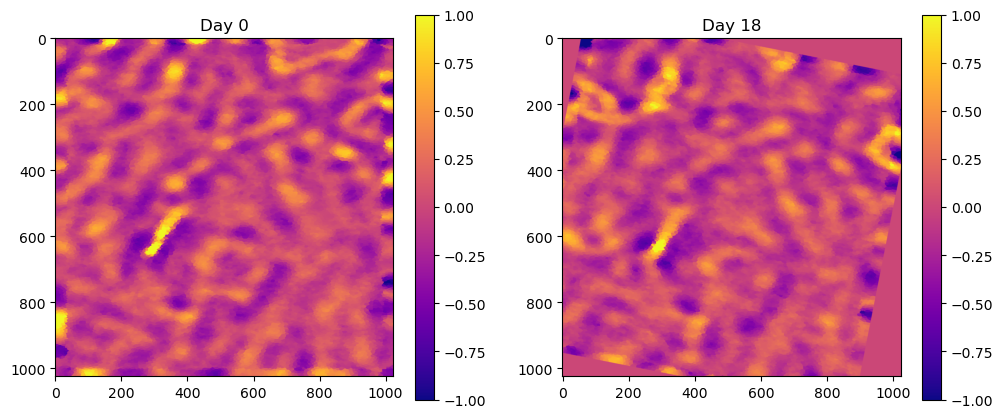

In [50]:
# rotation
from pystackreg import StackReg
from skimage import transform

Xtrim = slice(100,900)
Ytrim = slice(100,900)

sr = StackReg(StackReg.RIGID_BODY)
T = sr.register(t0_curve_grid[Xtrim,Ytrim],t1_curve_grid[Xtrim,Ytrim])
T = transform.EuclideanTransform(T)
# T = T + transform.EuclideanTransform(translation=[0,-5])
# T = T + transform.EuclideanTransform(rotation=np.deg2rad(1))
t1_curve_grid_transform = transform.warp(t1_curve_grid,T)

plt.subplot(1,2,1)
plt.title('Day 0')
plt.imshow(t0_curve_grid,clim=[-1,1],cmap='plasma')
# plt.pcolor(gridX,gridY,t0_curve_grid)
plt.clim([-1,1])
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Day 18')
plt.imshow(t1_curve_grid_transform,clim=[-1,1],cmap='plasma')
# plt.pcolor(gridX,gridY,t1_curve_grid)
plt.clim([-1,1])

plt.colorbar()

plt.savefig(path.join(dirname,'curvature.svg'))

stackview.switch({'t0':t0_curve_grid[Xtrim,Ytrim],
                  't1_raw':t1_curve_grid[Xtrim,Ytrim],
                  't1_reg':t1_curve_grid_transform[Xtrim,Ytrim]},
                 colormap=['pure_green','pure_magenta','pure_red'],
                 toggleable=True,zoom_factor=0.5)

In [69]:
(1197 -1*int(len(C)/4) )/2

399.0

0.49360709093312866


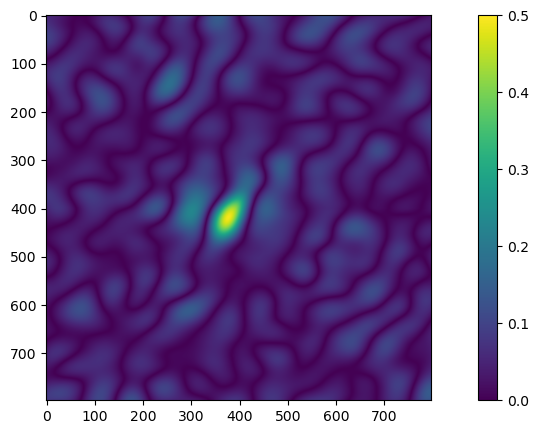

In [54]:
from mathUtils import normxcorr2

C = normxcorr2(t0_curve_grid[Xtrim,Ytrim],t1_curve_grid_transform[Xtrim,Ytrim])
fig = plt.figure()
plt.imshow(C[ 1*int(len(C)/4):3*int(len(C)/4), 1*int(len(C)/4):3*int(len(C)/4) ])
plt.clim([0,.5])

fig.gca().set_aspect('equal', 'box')
plt.colorbar()
fig.savefig(path.join(dirname,'spatial_correlation.svg'))
print(C.max())

# Save

In [52]:
# Plot alongside the raw images
t0_R = io.imread(path.join(dirname,'0. Day 0/G_reg.tif'))
t1_R = io.imread(path.join(dirname,'1. Day 18/G_reg.tif'))

MIP_t0_R = t0_R.max(axis=0)[Y_trim,X_trim]
MIP_t1_R = t1_R.max(axis=0)[Y_trim,X_trim]

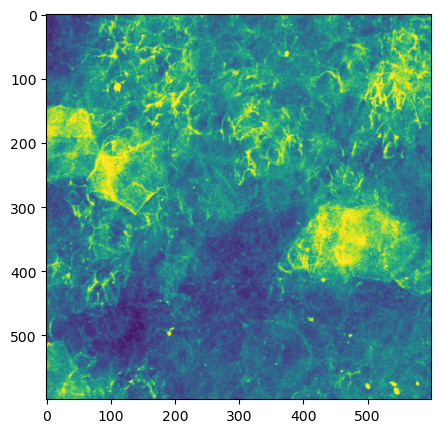

In [53]:
plt.imshow(MIP_t0_R)

In [67]:
t0_curvature

array([-1.67449531, -0.54555334,  0.0944696 , ...,  0.5581811 ,
        0.50719127,  0.5701386 ])

# Use curvature to auto align time points

In [46]:
from trimesh import registration
from scipy.spatial.transform import Rotation

T,_ = registration.mesh_other(t0_mesh,t1_mesh)

pl = pv.Plotter()
pl.add_mesh(t0_mesh,color='red')
pl.add_mesh(t1_mesh)
pl.show()

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x35b834dd0_10&reconnect=auto" class="pyvist…

In [45]:


# transforming mesh1
t1_mesh_transformed = t1_mesh.copy()
t1_mesh_transformed.apply_transform(T)

pl = pv.Plotter()
pl.add_mesh(t0_mesh,color='red')
pl.add_mesh(t1_mesh)
pl.show()

# saving mesh1 as STL file
# mesh1.export('rigidly_aligned_mesh.stl')

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x3a9ea3140_9&reconnect=auto" class="pyvista…

In [47]:
T

array([[ 0.99868526,  0.01642206, -0.0485599 ,  3.4688129 ],
       [-0.01477884,  0.99931233,  0.03400659,  4.04918631],
       [ 0.04908496, -0.03324422,  0.9982412 , 11.27674525],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [33]:
from scipy import ndimage

t1_crop_transformed = ndimage.affine_transform(t1_crop,T)

stackview.slice(t1_crop)

In [5]:
import trimesh
mesh = trimesh.load_mesh('/Users/xies/Downloads/Stanford_Bunny.stl')

pl = pv.Plotter()
pl.add_mesh(pv.wrap(mesh))
pl.show()

Widget(value='<iframe src="http://localhost:56926/index.html?ui=P_0x32179a750_0&reconnect=auto" class="pyvista…

In [6]:
curv = get_tissue_curvatures(mesh)

In [9]:
curv[0].shape

(56203,)